In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go

In [3]:
train=pd.read_csv("stk_hld_train.csv")
test=pd.read_csv("stk_hld_test.csv")

## train은 16년 1월 ~ 20년 12월 사이의 고객의 국내주식 거래가 종료된 건
## test는 20년 12월 이전에 매수하고 21년 이후에 고객이 전량 매도한 국내주식 보유기간 예측

In [4]:
train.head()

,act_id,iem_cd,byn_dt,hold_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,20180726,11
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,20180131,80
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,20180517,5
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A003520,20201112,22
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A002310,20180905,324


In [5]:
test.head()

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A032640,20200522,153,IDX00001,0
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A160600,20190823,335,IDX00002,0
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A234340,20200611,139,IDX00003,0
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A131760,20200120,236,IDX00004,0
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A293490,20201217,9,IDX00005,0


In [6]:
train.shape

(681472, 4)

In [7]:
test.shape

(70596, 6)

### stk_hld_test 데이터에는 stk_hld_train 데이터에 없는 column이  있다. 바로"hist_d" 인데
### "hist_d"는 stk_hld_test데이터에 속한 고객이 2021년 이전에 주식을 보유한 기간

## stk_bnc_hist.csv를 보면 train과 test고객의 과거 주식 정보를 알 수 있다. 이를 활용하여  past_d column 을 생성하여 사용한다.


# 라이브러리 불럭오기

In [8]:
import pandas as pd
pd.set_option("display.max_row",100)
pd.set_option("display.max_column",100)
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from lightgbm import LGBMRegressor


# 데이터 불러오기

In [9]:
cus = pd.read_csv("cus_info.csv")
iem = pd.read_csv("iem_info_20210902.csv")
hist = pd.read_csv("stk_bnc_hist.csv")
train = pd.read_csv("stk_hld_train.csv")
test = pd.read_csv("stk_hld_test.csv")

submission = pd.read_csv("sample_submission.csv")

# 데이터 전처리

In [10]:
train['hist_d']=train['hold_d']*0.6
train.hist_d=np.trunc(train['hist_d']) #trunc 함수 = 버림

In [11]:
train.head()

,act_id,iem_cd,byn_dt,hold_d,hist_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,20180726,11,6.0
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,20180131,80,48.0
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,20180517,5,3.0
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A003520,20201112,22,13.0
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A002310,20180905,324,194.0


In [12]:
# train과 test에 고객정보(cus_info)와 주식정보(iem_info)를 추가하겠습니다.
train_data = pd.merge(train,cus,how="left",on=['act_id'])
train_data = pd.merge(train_data,iem,how="left",on=["iem_cd"])

test_data = pd.merge(test,cus,how="left",on=['act_id'])
test_data = pd.merge(test_data,iem,how="left",on=["iem_cd"])


In [13]:
train_data.head()

,act_id,iem_cd,byn_dt,hold_d,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,20180726,11,6.0,1,9,3,2,2,9,5,5,8,GS건설,1,1,1
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,20180131,80,48.0,1,9,3,2,2,9,5,5,8,삼성전자,9,1,1
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,20180517,5,3.0,1,9,3,2,2,9,5,5,8,코스모신소재,12,2,99
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A003520,20201112,22,13.0,1,9,3,2,2,9,5,5,8,영진약품,8,2,1
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A002310,20180905,324,194.0,1,9,3,2,2,9,5,5,8,아세아제지,10,3,99


In [14]:
# train_data에서 Y값을 추출한 후 hold_d column을 지워준다. 
train_label=train_data["hold_d"]
train_data.drop(['hold_d'],axis=1,inplace=True)

In [15]:
hist = pd.read_csv("stk_bnc_hist.csv")
hist

,act_id,bse_dt,iem_cd,bnc_qty,tot_aet_amt,stk_par_pr
0,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200820,A008770,40.0,2828000.0,5000.0
1,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A008770,20.0,1390000.0,5000.0
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20160104,A005940,311.0,2982490.0,5000.0
3,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200814,A005930,40.0,2320000.0,100.0
4,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A005930,20.0,1028000.0,100.0
...,...,...,...,...,...,...
2573834,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,20200806,A035720,1.0,364000.0,500.0
2573835,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,20200813,A035720,0.0,0.0,500.0
2573836,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,20200819,A035720,1.0,376500.0,500.0
2573837,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,20200825,A035720,0.0,0.0,500.0


In [16]:
hist[:30]

,act_id,bse_dt,iem_cd,bnc_qty,tot_aet_amt,stk_par_pr
0,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200820,A008770,40.0,2828000.0,5000.0
1,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A008770,20.0,1390000.0,5000.0
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20160104,A005940,311.0,2982490.0,5000.0
3,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200814,A005930,40.0,2320000.0,100.0
4,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A005930,20.0,1028000.0,100.0
5,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200903,A005880,0.0,0.0,5000.0
6,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20170904,A005880,150.0,5265000.0,5000.0
7,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20170706,A005490,15.0,4410000.0,5000.0
8,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200811,A003620,0.0,0.0,5000.0
9,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20160104,A003620,270.0,2087100.0,5000.0


In [17]:
hist['stk_p']=hist['tot_aet_amt']/hist['bnc_qty'] # 잔고 하나당 금액
hist=hist.fillna(0)

In [18]:
train_data = pd.merge(train_data,hist,how = "left", on=["act_id","iem_cd"])
train_data = train_data[(train_data['byn_dt']==train_data['bse_dt'])]
train_data.reset_index(drop=True, inplace=True)

test_data = pd.merge(test_data, hist, how = "left", on = ["act_id", "iem_cd"])
test_data = test_data[(test_data["byn_dt"] == test_data["bse_dt"])]
test_data.reset_index(drop = True, inplace = True)

train_data = train_data.drop(["act_id", "iem_cd", "byn_dt", "bse_dt"], axis = 1)
test_data = test_data.drop(["act_id", "iem_cd", "byn_dt", "submit_id", "hold_d", "bse_dt"], axis = 1)

L_encoder=LabelEncoder()
L_encoder.fit(iem['iem_krl_nm'])
train_data['iem_krl_nm']=L_encoder.transform(train_data['iem_krl_nm'])
test_data['iem_krl_nm']=L_encoder.transform(test_data['iem_krl_nm'])

In [19]:
train_data.head()

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,6.0,1,9,3,2,2,9,5,5,8,101,1,1,1,274.0,11782000.0,5000.0,43000.0
1,48.0,1,9,3,2,2,9,5,5,8,1361,9,1,1,2.0,4990000.0,5000.0,2495000.0
2,3.0,1,9,3,2,2,9,5,5,8,2530,12,2,99,786.0,14619600.0,1000.0,18600.0
3,13.0,1,9,3,2,2,9,5,5,8,1969,8,2,1,60.0,462000.0,500.0,7700.0
4,194.0,1,9,3,2,2,9,5,5,8,1696,10,3,99,183.0,8125200.0,5000.0,44400.0


In [20]:
train_data.iem_krl_nm.value_counts()

1361    11005
506      5650
2448     4854
2998     4178
1528     3601
        ...  
31          1
1666        1
131         1
2591        1
2812        1
Name: iem_krl_nm, Length: 2780, dtype: int64

In [21]:
train_data.reset_index(drop=True,inplace=True)
train_label.reset_index(drop=True,inplace=True) #y값


In [22]:
train_label

0          11
1          80
2           5
3          22
4         324
         ... 
681467      1
681468      1
681469      1
681470      1
681471      1
Name: hold_d, Length: 681472, dtype: int64

In [23]:
train_data

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,6.0,1,9,3,2,2,9,5,5,8,101,1,1,1,274.0,11782000.0,5000.0,43000.0
1,48.0,1,9,3,2,2,9,5,5,8,1361,9,1,1,2.0,4990000.0,5000.0,2495000.0
2,3.0,1,9,3,2,2,9,5,5,8,2530,12,2,99,786.0,14619600.0,1000.0,18600.0
3,13.0,1,9,3,2,2,9,5,5,8,1969,8,2,1,60.0,462000.0,500.0,7700.0
4,194.0,1,9,3,2,2,9,5,5,8,1696,10,3,99,183.0,8125200.0,5000.0,44400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681467,0.0,1,4,4,2,2,3,4,3,8,1752,10,3,99,199.0,3532250.0,500.0,17750.0
681468,0.0,1,4,4,2,2,3,4,3,8,2344,8,2,99,488.0,22960400.0,500.0,47050.0
681469,0.0,1,4,4,2,2,3,4,3,8,521,2,2,99,2210.0,9204650.0,500.0,4165.0
681470,0.0,1,4,4,2,2,3,4,3,8,2460,2,3,99,285.0,2721750.0,500.0,9550.0


In [24]:
train_label

0          11
1          80
2           5
3          22
4         324
         ... 
681467      1
681468      1
681469      1
681470      1
681471      1
Name: hold_d, Length: 681472, dtype: int64

# 모델학습 :LGBMRegressor사용

In [26]:
# 데이터 분리
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, train_test_split
#모델
from lightgbm import LGBMRegressor

y=train_label
X=train_data

train_x,val_x,train_y,val_y=train_test_split(X,y,test_size=0.25,random_state=1)

model = LGBMRegressor(objective= "regression",
                          max_depth= 10,
                          n_estimators= 2000,
                          learning_rate= 0.01,
                          num_leaves = 31)

model.fit(train_x, train_y,
              eval_set=[(val_x, val_y)],
              eval_metric=["rmse"],
              early_stopping_rounds=100,
              verbose=500)

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.982915	valid_0's l2: 0.966122
Early stopping, best iteration is:
[597]	valid_0's rmse: 0.935858	valid_0's l2: 0.87583


LGBMRegressor(learning_rate=0.01, max_depth=10, n_estimators=2000,
              objective='regression')

In [27]:
model

LGBMRegressor(learning_rate=0.01, max_depth=10, n_estimators=2000,
              objective='regression')

# featrue importance를 통해서 가장 먼저 살펴볼 변수를 선정한다

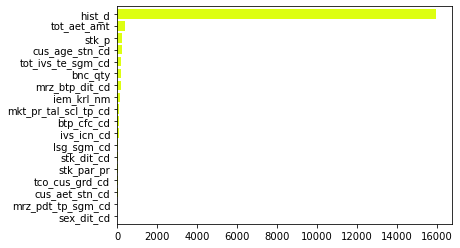

In [31]:
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,color='#ddff11')
#fig=plt.gcf()
#fig.set_size_inches(30,28)
plt.show()

# hist_d가 없을 때 feature importance를 보자

In [32]:
# 데이터 분리
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, train_test_split
#모델
from lightgbm import LGBMRegressor

y=train_label
X=train_data.drop(["hist_d"], axis = 1)

train_x,val_x,train_y,val_y=train_test_split(X,y,test_size=0.25,random_state=1)

model = LGBMRegressor(objective= "regression",
                          max_depth= 10,
                          n_estimators= 2000,
                          learning_rate= 0.01,
                          num_leaves = 31)

model.fit(train_x, train_y,
              eval_set=[(val_x, val_y)],
              eval_metric=["rmse"],
              early_stopping_rounds=100,
              verbose=500)

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 49.5345	valid_0's l2: 2453.67
[1000]	valid_0's rmse: 49.2601	valid_0's l2: 2426.56
[1500]	valid_0's rmse: 49.1178	valid_0's l2: 2412.56
[2000]	valid_0's rmse: 48.9996	valid_0's l2: 2400.97
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 48.9996	valid_0's l2: 2400.97


LGBMRegressor(learning_rate=0.01, max_depth=10, n_estimators=2000,
              objective='regression')

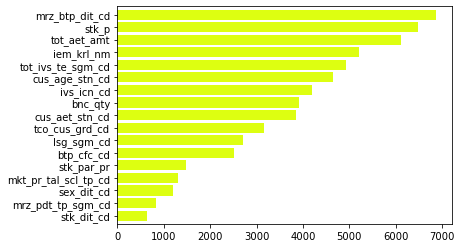

In [33]:
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,color='#ddff11')
#fig=plt.gcf()
#fig.set_size_inches(30,28)
plt.show()

In [34]:
test_data

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,153,1,9,3,2,2,9,5,5,8,418,4,1,1,300.0,3945000.0,5000.0,13150.0
1,335,1,9,3,2,2,9,5,5,8,2230,10,3,99,198.0,2524500.0,500.0,12750.0
2,139,1,9,3,2,2,9,5,5,8,1515,13,2,99,138.0,4291800.0,500.0,31100.0
3,236,1,9,3,2,2,9,5,5,8,2681,13,3,99,2972.0,6716720.0,500.0,2260.0
4,9,1,9,3,2,2,9,5,5,8,2450,13,1,2,10.0,464500.0,100.0,46450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70591,23,1,6,0,5,2,5,3,5,2,1369,2,1,1,1.0,198500.0,500.0,198500.0
70592,103,1,6,0,5,2,5,3,5,2,444,2,99,99,50.0,372000.0,5000.0,7440.0
70593,858,1,4,4,2,2,3,4,3,8,1280,14,3,99,75057.0,3677793.0,100.0,49.0
70594,11,1,4,4,2,2,3,4,3,8,2373,8,2,99,96.0,11424000.0,2500.0,119000.0


In [37]:
# hist없이
test_X=test_data.drop(['hist_d'],axis=1)
test_X

,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,1,9,3,2,2,9,5,5,8,418,4,1,1,300.0,3945000.0,5000.0,13150.0
1,1,9,3,2,2,9,5,5,8,2230,10,3,99,198.0,2524500.0,500.0,12750.0
2,1,9,3,2,2,9,5,5,8,1515,13,2,99,138.0,4291800.0,500.0,31100.0
3,1,9,3,2,2,9,5,5,8,2681,13,3,99,2972.0,6716720.0,500.0,2260.0
4,1,9,3,2,2,9,5,5,8,2450,13,1,2,10.0,464500.0,100.0,46450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70591,1,6,0,5,2,5,3,5,2,1369,2,1,1,1.0,198500.0,500.0,198500.0
70592,1,6,0,5,2,5,3,5,2,444,2,99,99,50.0,372000.0,5000.0,7440.0
70593,1,4,4,2,2,3,4,3,8,1280,14,3,99,75057.0,3677793.0,100.0,49.0
70594,1,4,4,2,2,3,4,3,8,2373,8,2,99,96.0,11424000.0,2500.0,119000.0


In [38]:
predict=model.predict(test_X)
predict

array([15.35382358, 14.87397296, 14.24630307, ..., 16.78730758,
       14.89777858, 19.93223611])

In [39]:
sub_no_hist=submission.copy()

In [40]:
sub_no_hist['hold_d']=np.round(predict)
sub_no_hist['hist_d1']=test_data['hist_d']+1
sub_no_hist['max_d']=test_data['hist_d']+146

In [41]:
maxvs=sub_no_hist[['hold_d','max_d']]
maxvs['pred_max']=maxvs.min(axis=1)

In [42]:
minvs=pd.DataFrame(sub_no_hist['hist_d1'])
minvs['pred_max']=maxvs['pred_max']
minvs['pred_final']=minvs.max(axis=1)

In [43]:
minvs

,hist_d1,pred_max,pred_final
0,154,15.0,154.0
1,336,15.0,336.0
2,140,14.0,140.0
3,237,15.0,237.0
4,10,13.0,13.0
...,...,...,...
70591,24,38.0,38.0
70592,104,42.0,104.0
70593,859,17.0,859.0
70594,12,15.0,15.0


In [44]:
sub_base_no_hist=submission.copy()
sub_base_no_hist['hold_d']=minvs['pred_final']

In [45]:
sub_base_no_hist.to_csv('sub_no_hist_0904.csv',index=False)

In [24]:
models = []

folds = KFold(n_splits=10)
for train_idx, val_idx in folds.split(train_data):
    
    train_x = train_data.iloc[train_idx, :]
    train_y = train_label[train_idx]
    val_x = train_data.iloc[val_idx, :]
    val_y = train_label[val_idx]
    
    model = LGBMRegressor(objective= "regression",
                          max_depth= 10,
                          n_estimators= 2000,
                          learning_rate= 0.01,
                          num_leaves = 31)
    
    model.fit(train_x, train_y,
              eval_set=[(val_x, val_y)],
              eval_metric=["rmse"],
              early_stopping_rounds=300,
              verbose=500)
    
    models.append(model)

Training until validation scores don't improve for 300 rounds
[500]	valid_0's rmse: 4.21462	valid_0's l2: 17.763
[1000]	valid_0's rmse: 4.08221	valid_0's l2: 16.6645
[1500]	valid_0's rmse: 4.04658	valid_0's l2: 16.3748
[2000]	valid_0's rmse: 4.02865	valid_0's l2: 16.23
Did not meet early stopping. Best iteration is:
[1999]	valid_0's rmse: 4.0286	valid_0's l2: 16.2296
Training until validation scores don't improve for 300 rounds
[500]	valid_0's rmse: 1.25851	valid_0's l2: 1.58384
[1000]	valid_0's rmse: 1.24109	valid_0's l2: 1.54031
Early stopping, best iteration is:
[710]	valid_0's rmse: 1.2014	valid_0's l2: 1.44337
Training until validation scores don't improve for 300 rounds
[500]	valid_0's rmse: 0.686836	valid_0's l2: 0.471744
[1000]	valid_0's rmse: 0.474476	valid_0's l2: 0.225127
Early stopping, best iteration is:
[972]	valid_0's rmse: 0.474298	valid_0's l2: 0.224958
Training until validation scores don't improve for 300 rounds
[500]	valid_0's rmse: 0.574849	valid_0's l2: 0.330452
[

In [25]:
models

[LGBMRegressor(learning_rate=0.01, max_depth=10, n_estimators=2000,
               objective='regression'),
 LGBMRegressor(learning_rate=0.01, max_depth=10, n_estimators=2000,
               objective='regression'),
 LGBMRegressor(learning_rate=0.01, max_depth=10, n_estimators=2000,
               objective='regression'),
 LGBMRegressor(learning_rate=0.01, max_depth=10, n_estimators=2000,
               objective='regression'),
 LGBMRegressor(learning_rate=0.01, max_depth=10, n_estimators=2000,
               objective='regression'),
 LGBMRegressor(learning_rate=0.01, max_depth=10, n_estimators=2000,
               objective='regression'),
 LGBMRegressor(learning_rate=0.01, max_depth=10, n_estimators=2000,
               objective='regression'),
 LGBMRegressor(learning_rate=0.01, max_depth=10, n_estimators=2000,
               objective='regression'),
 LGBMRegressor(learning_rate=0.01, max_depth=10, n_estimators=2000,
               objective='regression'),
 LGBMRegressor(learning_rate

# 결과 추론

In [26]:
# 10개의 cross validation의 최종 모델을 전부 활용하여 
# test데이터를 예측하고 그 평균값을 사용한다.
result=[]
for i in models:
    result.append(i.predict(test_data))
predict = np.mean(result,axis=0)
    

In [27]:
predict

array([254.6816648 , 557.53185139, 232.1511592 , ..., 863.03262758,
        18.99839648,   7.47364842])

In [28]:
sub_depth10_base=submission.copy()

In [29]:
sub_depth10_base['hold_d']=np.round(predict)

In [30]:
sub_depth10_base

,submit_id,hold_d
0,IDX00001,255.0
1,IDX00002,558.0
2,IDX00003,232.0
3,IDX00004,394.0
4,IDX00005,15.0
...,...,...
70591,IDX70592,39.0
70592,IDX70593,172.0
70593,IDX70594,863.0
70594,IDX70595,19.0


In [31]:
test_data

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,153,1,9,3,2,2,9,5,5,8,418,4,1,1,300.0,3945000.0,5000.0,13150.0
1,335,1,9,3,2,2,9,5,5,8,2230,10,3,99,198.0,2524500.0,500.0,12750.0
2,139,1,9,3,2,2,9,5,5,8,1515,13,2,99,138.0,4291800.0,500.0,31100.0
3,236,1,9,3,2,2,9,5,5,8,2681,13,3,99,2972.0,6716720.0,500.0,2260.0
4,9,1,9,3,2,2,9,5,5,8,2450,13,1,2,10.0,464500.0,100.0,46450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70591,23,1,6,0,5,2,5,3,5,2,1369,2,1,1,1.0,198500.0,500.0,198500.0
70592,103,1,6,0,5,2,5,3,5,2,444,2,99,99,50.0,372000.0,5000.0,7440.0
70593,858,1,4,4,2,2,3,4,3,8,1280,14,3,99,75057.0,3677793.0,100.0,49.0
70594,11,1,4,4,2,2,3,4,3,8,2373,8,2,99,96.0,11424000.0,2500.0,119000.0


In [34]:
sub_depth10_base['hist_d1']=test_data['hist_d']+1
sub_depth10_base['max_d']=test_data['hist_d']+146

In [35]:
maxvs=sub_depth10_base[['hold_d','max_d']]

## hold_d>hist_d1 & hold_d<max_d

In [36]:
maxvs=sub_depth10_base[['hold_d','max_d']]
maxvs['pred_max']=maxvs.min(axis=1)

In [37]:
maxvs

,hold_d,max_d,pred_max
0,255.0,299,255.0
1,558.0,481,481.0
2,232.0,285,232.0
3,394.0,382,382.0
4,15.0,155,15.0
...,...,...,...
70591,39.0,169,39.0
70592,172.0,249,172.0
70593,863.0,1004,863.0
70594,19.0,157,19.0


In [44]:
minvs=pd.DataFrame(sub_depth10_base['hist_d1'])
minvs['pred_max']=maxvs['pred_max']
minvs['pred_final']=minvs.max(axis=1)

In [45]:
minvs

,hist_d1,pred_max,pred_final
0,154,255.0,255.0
1,336,481.0,481.0
2,140,232.0,232.0
3,237,382.0,382.0
4,10,15.0,15.0
...,...,...,...
70591,24,39.0,39.0
70592,104,172.0,172.0
70593,859,863.0,863.0
70594,12,19.0,19.0


In [46]:
sub_base=submission.copy()
sub_base['hold_d']=minvs['pred_final']

In [48]:
sub_base.to_csv('sub_basee.csv',index=False)

# hist_duration의 효과가 어디에서 어느정도로 모델에 적용되었는지 살펴보고자 한다.

In [31]:
test_data['0.6_pred']=test_data['hist_d']*(10/6)

In [34]:
sub_depth10_base['0.6_pred']=np.round(test_data['0.6_pred'].copy())


In [35]:
sub_depth10_base

,submit_id,hold_d,0.6_pred
0,IDX00001,255.0,255.0
1,IDX00002,558.0,558.0
2,IDX00003,232.0,232.0
3,IDX00004,394.0,393.0
4,IDX00005,15.0,15.0
...,...,...,...
70591,IDX70592,39.0,38.0
70592,IDX70593,172.0,172.0
70593,IDX70594,863.0,1430.0
70594,IDX70595,19.0,18.0


In [42]:
sub_depth10_base['diff']=np.abs(sub_depth10_base['hold_d']-sub_depth10_base['0.6_pred'])

In [43]:
sub_depth10_base

,submit_id,hold_d,0.6_pred,diff
0,IDX00001,255.0,255.0,0.0
1,IDX00002,558.0,558.0,0.0
2,IDX00003,232.0,232.0,0.0
3,IDX00004,394.0,393.0,1.0
4,IDX00005,15.0,15.0,0.0
...,...,...,...,...
70591,IDX70592,39.0,38.0,1.0
70592,IDX70593,172.0,172.0,0.0
70593,IDX70594,863.0,1430.0,567.0
70594,IDX70595,19.0,18.0,1.0


In [46]:
# 차이가 2이상인 데이터
ss2=sub_depth10_base[sub_depth10_base['diff']>=2]
ss2

,submit_id,hold_d,0.6_pred,diff
7,IDX00008,905.0,1200.0,295.0
9,IDX00010,877.0,850.0,27.0
11,IDX00012,891.0,2045.0,1154.0
12,IDX00013,893.0,778.0,115.0
21,IDX00022,857.0,2045.0,1188.0
...,...,...,...,...
70572,IDX70573,180.0,178.0,2.0
70575,IDX70576,180.0,178.0,2.0
70580,IDX70581,860.0,2045.0,1185.0
70586,IDX70587,185.0,183.0,2.0


In [47]:
ss2.describe()

,hold_d,0.6_pred,diff
count,7860.000000,7860.000000,7860.000000
mean,663.743893,773.254198,118.174427
std,256.196589,370.314782,163.539085
min,170.000000,168.000000,2.000000
25%,407.250000,405.250000,2.000000
50%,831.000000,803.000000,31.000000
75%,851.000000,1067.000000,216.000000
max,944.000000,2045.000000,1188.000000


# TRAIN에서 주식 보유기간이 길수록 과거 보유기간 외의 다른 변수의 영향이 모델에 강적용되었음을 볼 수 있다.

In [48]:
# 차이가 3이상인 데이터
ss3=sub_depth10_base[sub_depth10_base['diff']>=3]
ss3

,submit_id,hold_d,0.6_pred,diff
7,IDX00008,905.0,1200.0,295.0
9,IDX00010,877.0,850.0,27.0
11,IDX00012,891.0,2045.0,1154.0
12,IDX00013,893.0,778.0,115.0
21,IDX00022,857.0,2045.0,1188.0
...,...,...,...,...
64010,IDX64011,649.0,652.0,3.0
64094,IDX64095,466.0,462.0,4.0
64246,IDX64247,575.0,572.0,3.0
70580,IDX70581,860.0,2045.0,1185.0


In [49]:
ss3.describe()

,hold_d,0.6_pred,diff
count,5381.000000,5381.000000,5381.00000
mean,822.456421,983.214830,171.69541
std,66.109941,220.929248,173.16083
min,352.000000,348.000000,3.00000
25%,828.000000,787.000000,24.00000
50%,845.000000,982.000000,128.00000
75%,858.000000,1113.000000,261.00000
max,944.000000,2045.000000,1188.00000


# Train에서 Test와 비슷한 데이터 셋을 만들고자 한다.
# Test의 hist_d의 범위를 한번 본다

In [51]:
test_data.describe()

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,0.6_pred
count,70596.000000,70596.000000,70596.000000,70596.000000,70596.000000,70596.000000,70596.000000,70596.000000,70596.000000,70596.000000,70596.000000,70596.000000,70596.000000,70596.000000,70596.000000,7.059600e+04,70596.000000,7.059600e+04,70596.000000
mean,113.240849,1.457958,4.899527,30.554522,3.000907,2.035243,4.649895,5.185577,2.817128,10.020341,1601.627755,8.754080,9.901765,54.193297,407.622811,3.808452e+06,1442.022211,6.274735e+04,188.734749
std,162.830480,0.498233,2.094544,43.172335,1.574875,0.398494,1.898982,4.556777,0.979824,3.507011,857.351586,3.517422,26.674236,48.688413,3588.029721,3.543835e+07,1885.455557,1.184758e+05,271.384133
min,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.600000e+01,0.000000,1.800000e+01,1.666667
25%,14.000000,1.000000,3.000000,3.000000,2.000000,2.000000,3.000000,4.000000,2.000000,8.000000,921.000000,6.000000,1.000000,1.000000,5.000000,1.985700e+05,500.000000,7.140000e+03,23.333333
50%,56.000000,1.000000,5.000000,4.000000,3.000000,2.000000,5.000000,4.000000,3.000000,10.000000,1530.000000,9.000000,2.000000,99.000000,30.000000,7.740000e+05,500.000000,2.245000e+04,93.333333
75%,131.000000,2.000000,6.000000,99.000000,4.000000,2.000000,6.000000,5.000000,3.000000,13.000000,2358.000000,12.000000,3.000000,99.000000,142.000000,2.415000e+06,1000.000000,6.450000e+04,218.333333
max,1227.000000,2.000000,9.000000,99.000000,6.000000,15.000000,9.000000,99.000000,6.000000,16.000000,3074.000000,14.000000,99.000000,99.000000,460000.000000,7.830000e+09,10000.000000,2.853000e+06,2045.000000


In [53]:
test_data.hist_d

0        153
1        335
2        139
3        236
4          9
        ... 
70591     23
70592    103
70593    858
70594     11
70595      4
Name: hist_d, Length: 70596, dtype: int64

### 2020년 주말을 제외하고 주식시장이 열리지 않은 날은 14일이다.
https://kr.investing.com/holiday-calendar/
### 일요일 52일, 토요일 52일 => 104일 
## 그러므로 2020년에 주식을 샀을 경우 과거 주식 보유일의 max는 365-(104+14)=257일이다

## 2020년 이전에 구입한 주식은 따로 보기로 한다.

In [54]:
pre_2020=test_data[test_data['hist_d']>257]
pre_2020

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,0.6_pred
1,335,1,9,3,2,2,9,5,5,8,2230,10,3,99,198.0,2524500.0,500.0,12750.0,558.333333
7,720,1,6,0,3,2,5,5,6,9,2328,7,3,99,500.0,5125000.0,500.0,10250.0,1200.000000
9,510,1,6,0,3,2,5,5,6,9,1206,10,3,99,50.0,337500.0,2500.0,6750.0,850.000000
11,1227,1,4,99,1,2,3,3,6,16,2044,14,1,1,340.0,2924000.0,5000.0,8600.0,2045.000000
12,467,1,4,99,1,2,3,3,6,16,2033,2,1,1,340.0,5202000.0,5000.0,15300.0,778.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64827,365,2,2,99,6,2,2,2,3,16,1791,13,3,99,990.0,5138100.0,500.0,5190.0,608.333333
70580,1227,1,6,0,5,2,5,3,5,2,884,9,3,99,160.0,939200.0,1000.0,5870.0,2045.000000
70587,287,1,6,0,5,2,5,3,5,2,405,14,1,1,1.0,100500.0,5000.0,100500.0,478.333333
70588,357,1,6,0,5,2,5,3,5,2,505,4,1,1,1.0,257500.0,500.0,257500.0,595.000000


In [55]:
pre_2020.describe()

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,0.6_pred
count,8285.000000,8285.000000,8285.000000,8285.000000,8285.000000,8285.000000,8285.000000,8285.000000,8285.000000,8285.000000,8285.000000,8285.000000,8285.000000,8285.000000,8285.000000,8.285000e+03,8285.000000,8.285000e+03,8285.000000
mean,500.418950,1.435244,5.087266,39.666626,3.031020,2.042607,4.871937,5.023054,3.416053,11.218588,1617.339046,8.710320,8.992396,60.650573,628.669403,6.006984e+06,1658.961979,5.227954e+04,834.031583
std,165.361489,0.495819,1.891361,46.293368,1.612625,0.468460,1.771983,2.347024,0.776967,4.082904,867.298977,3.790423,24.916099,47.736430,3518.230432,9.072589e+07,2003.110422,1.722312e+05,275.602482
min,258.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,4.000000e+01,0.000000,1.800000e+01,430.000000
25%,367.000000,1.000000,4.000000,3.000000,2.000000,2.000000,4.000000,3.000000,3.000000,9.000000,937.000000,5.000000,1.000000,1.000000,9.000000,1.835000e+05,500.000000,5.150000e+03,611.666667
50%,470.000000,1.000000,5.000000,5.000000,3.000000,2.000000,5.000000,4.000000,3.000000,10.000000,1590.000000,9.000000,2.000000,99.000000,50.000000,8.040000e+05,500.000000,1.503000e+04,783.333333
75%,637.000000,2.000000,6.000000,99.000000,4.000000,2.000000,6.000000,5.000000,4.000000,16.000000,2357.000000,12.000000,3.000000,99.000000,250.000000,2.795000e+06,5000.000000,4.600000e+04,1061.666667
max,1227.000000,2.000000,9.000000,99.000000,6.000000,15.000000,9.000000,9.000000,6.000000,16.000000,3074.000000,14.000000,99.000000,99.000000,112000.000000,7.830000e+09,10000.000000,2.853000e+06,2045.000000


# train에서 y값을 기반으로 만든 hist_d라는 말도 안되는 변수를 설정하였다. hist_d를 제외하고 변수들의 효과를 살펴보자

In [72]:
train_data

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,6.0,1,9,3,2,2,9,5,5,8,101,1,1,1,274.0,11782000.0,5000.0,43000.0
1,48.0,1,9,3,2,2,9,5,5,8,1361,9,1,1,2.0,4990000.0,5000.0,2495000.0
2,3.0,1,9,3,2,2,9,5,5,8,2530,12,2,99,786.0,14619600.0,1000.0,18600.0
3,13.0,1,9,3,2,2,9,5,5,8,1969,8,2,1,60.0,462000.0,500.0,7700.0
4,194.0,1,9,3,2,2,9,5,5,8,1696,10,3,99,183.0,8125200.0,5000.0,44400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681467,0.0,1,4,4,2,2,3,4,3,8,1752,10,3,99,199.0,3532250.0,500.0,17750.0
681468,0.0,1,4,4,2,2,3,4,3,8,2344,8,2,99,488.0,22960400.0,500.0,47050.0
681469,0.0,1,4,4,2,2,3,4,3,8,521,2,2,99,2210.0,9204650.0,500.0,4165.0
681470,0.0,1,4,4,2,2,3,4,3,8,2460,2,3,99,285.0,2721750.0,500.0,9550.0


In [73]:
train_no_hist=train_data.drop(['hist_d'],axis=1)
train_no_hist

,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,1,9,3,2,2,9,5,5,8,101,1,1,1,274.0,11782000.0,5000.0,43000.0
1,1,9,3,2,2,9,5,5,8,1361,9,1,1,2.0,4990000.0,5000.0,2495000.0
2,1,9,3,2,2,9,5,5,8,2530,12,2,99,786.0,14619600.0,1000.0,18600.0
3,1,9,3,2,2,9,5,5,8,1969,8,2,1,60.0,462000.0,500.0,7700.0
4,1,9,3,2,2,9,5,5,8,1696,10,3,99,183.0,8125200.0,5000.0,44400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681467,1,4,4,2,2,3,4,3,8,1752,10,3,99,199.0,3532250.0,500.0,17750.0
681468,1,4,4,2,2,3,4,3,8,2344,8,2,99,488.0,22960400.0,500.0,47050.0
681469,1,4,4,2,2,3,4,3,8,521,2,2,99,2210.0,9204650.0,500.0,4165.0
681470,1,4,4,2,2,3,4,3,8,2460,2,3,99,285.0,2721750.0,500.0,9550.0


# 동일하게 LGBMRegressor사용

In [75]:
models = []

folds = KFold(n_splits=10)
for train_idx, val_idx in folds.split(train_no_hist):
    
    train_x = train_no_hist.iloc[train_idx, :]
    train_y = train_label[train_idx]
    val_x = train_no_hist.iloc[val_idx, :]
    val_y = train_label[val_idx]
    
    model = LGBMRegressor(objective= "regression",
                          max_depth= 5,
                          n_estimators= 2000,
                          learning_rate= 0.01,
                          num_leaves = 31)
    
    model.fit(train_x, train_y,
              eval_set=[(val_x, val_y)],
              eval_metric=["rmse"],
              early_stopping_rounds=300,
              verbose=500)
    
    models.append(model)

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[121]	valid_0's rmse: 64.2772	valid_0's l2: 4131.55
Training until validation scores don't improve for 300 rounds
[500]	valid_0's rmse: 71.2439	valid_0's l2: 5075.69
[1000]	valid_0's rmse: 71.0587	valid_0's l2: 5049.34
Early stopping, best iteration is:
[1013]	valid_0's rmse: 71.0557	valid_0's l2: 5048.92
Training until validation scores don't improve for 300 rounds
[500]	valid_0's rmse: 74.1089	valid_0's l2: 5492.13
[1000]	valid_0's rmse: 73.9349	valid_0's l2: 5466.37
[1500]	valid_0's rmse: 73.8612	valid_0's l2: 5455.48
[2000]	valid_0's rmse: 73.777	valid_0's l2: 5443.05
Did not meet early stopping. Best iteration is:
[1984]	valid_0's rmse: 73.7766	valid_0's l2: 5442.99
Training until validation scores don't improve for 300 rounds
[500]	valid_0's rmse: 61.177	valid_0's l2: 3742.63
[1000]	valid_0's rmse: 61.0647	valid_0's l2: 3728.9
[1500]	valid_0's rmse: 60.9915	valid_0's l2: 3719.97
[2000

In [76]:
models

[LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=2000,
               objective='regression'),
 LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=2000,
               objective='regression'),
 LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=2000,
               objective='regression'),
 LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=2000,
               objective='regression'),
 LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=2000,
               objective='regression'),
 LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=2000,
               objective='regression'),
 LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=2000,
               objective='regression'),
 LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=2000,
               objective='regression'),
 LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=2000,
               objective='regression'),
 LGBMRegressor(learning_rate=0.01, ma

In [78]:
test_no_hist=test_data.drop(['hist_d'],axis=1)

In [82]:
result_no_hist=[]
for i in models:
    result_no_hist.append(i.predict(test_no_hist))
predict_no_hist = np.mean(result_no_hist,axis=0)

In [96]:
sub_no_hist=submission.copy()
sub_no_hist

,submit_id,hold_d
0,IDX00001,0
1,IDX00002,0
2,IDX00003,0
3,IDX00004,0
4,IDX00005,0
...,...,...
70591,IDX70592,0
70592,IDX70593,0
70593,IDX70594,0
70594,IDX70595,0


In [97]:
sub_no_hist['hist_1']=test_data['hist_d']+1
sub_no_hist['pred']=np.round(predict_no_hist)

In [98]:
sub_no_hist

,submit_id,hold_d,hist_1,pred
0,IDX00001,0,154,15.0
1,IDX00002,0,336,15.0
2,IDX00003,0,140,15.0
3,IDX00004,0,237,15.0
4,IDX00005,0,10,14.0
...,...,...,...,...
70591,IDX70592,0,24,38.0
70592,IDX70593,0,104,38.0
70593,IDX70594,0,859,16.0
70594,IDX70595,0,12,16.0


In [102]:
hist_pred=sub_no_hist[['hist_1','pred']]
hist_pred['max']=hist_pred.max(axis=1)
hist_pred

,hist_1,pred,max
0,154,15.0,154.0
1,336,15.0,336.0
2,140,15.0,140.0
3,237,15.0,237.0
4,10,14.0,14.0
...,...,...,...
70591,24,38.0,38.0
70592,104,38.0,104.0
70593,859,16.0,859.0
70594,12,16.0,16.0


In [103]:
sub_no_hist1=submission.copy()
sub_no_hist1['hold_d']=hist_pred['hist_1']

In [105]:
sub_no_hist1.to_csv('sub_no_hist1.csv',index=False)

In [86]:
test_data

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,153,1,9,3,2,2,9,5,5,8,418,4,1,1,300.0,3945000.0,5000.0,13150.0
1,335,1,9,3,2,2,9,5,5,8,2230,10,3,99,198.0,2524500.0,500.0,12750.0
2,139,1,9,3,2,2,9,5,5,8,1515,13,2,99,138.0,4291800.0,500.0,31100.0
3,236,1,9,3,2,2,9,5,5,8,2681,13,3,99,2972.0,6716720.0,500.0,2260.0
4,9,1,9,3,2,2,9,5,5,8,2450,13,1,2,10.0,464500.0,100.0,46450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70591,23,1,6,0,5,2,5,3,5,2,1369,2,1,1,1.0,198500.0,500.0,198500.0
70592,103,1,6,0,5,2,5,3,5,2,444,2,99,99,50.0,372000.0,5000.0,7440.0
70593,858,1,4,4,2,2,3,4,3,8,1280,14,3,99,75057.0,3677793.0,100.0,49.0
70594,11,1,4,4,2,2,3,4,3,8,2373,8,2,99,96.0,11424000.0,2500.0,119000.0


In [43]:
train_label.value_counts()[:50]

1     190008
2      83359
3      52303
4      38318
5      29640
6      23497
7      19375
8      16358
9      13964
10     12234
11     10764
12      9761
13      8491
14      7901
15      7083
16      6489
17      6271
18      5647
19      5077
20      4647
21      4439
22      4000
23      3831
24      3635
25      3364
26      3290
27      3025
28      2922
29      2723
31      2579
30      2523
32      2522
33      2327
35      2125
34      2091
36      2009
37      1914
38      1868
39      1849
40      1748
41      1702
42      1624
44      1555
43      1543
45      1389
46      1371
48      1366
47      1317
49      1289
50      1284
Name: hold_d, dtype: int64

In [51]:
test['hist_d'].value_counts()[:40]

1     2356
2     1648
3     1643
6     1564
7     1449
5     1328
4     1286
8     1227
9     1126
12    1063
18     932
10     926
13     924
17     915
11     906
16     895
19     858
14     813
15     779
20     768
22     712
25     688
26     684
21     580
27     551
31     513
78     507
77     478
23     475
30     473
24     456
32     447
72     446
36     443
71     442
54     438
73     435
28     433
79     403
29     395
Name: hist_d, dtype: int64

In [49]:
test_77=test[test['hist_d']==77]
test_77

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d
35,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,A035420,20200908,77,IDX00036,0
269,141aa640948a63ffa54747efda8272da47e2d8846ee02d...,A118000,20200908,77,IDX00270,0
409,1c52768eebea2eab6a7ed8cc95d838a3732fc6dce51ba3...,A032500,20200908,77,IDX00410,0
435,1c52768eebea2eab6a7ed8cc95d838a3732fc6dce51ba3...,A230240,20200908,77,IDX00436,0
474,4932d54890232be3d59b064a348e9dc510044d5526b990...,A120110,20200908,77,IDX00475,0
...,...,...,...,...,...,...
69746,cfaf5ad885d0040dfb9777b74a88c9ade04b61fcc00d2f...,A033270,20200908,77,IDX69747,0
69843,dc31aad8528a1976d907efad65b97e3e0c41dd42e126d0...,A012450,20200908,77,IDX69844,0
69885,b7b078eab747c7d4ed6da70dc782df3467f21a35709419...,A011150,20200908,77,IDX69886,0
70228,42e8bb66a926a2c5a7e288b09eb8c249c927ab90d3245f...,A009830,20200908,77,IDX70229,0


In [50]:
test_78=test[test['hist_d']==78]
test_78

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d
200,43a0eb89f16d3a46767794dda9c31cd15e1ff9daf33332...,A101490,20200907,78,IDX00201,0
410,1c52768eebea2eab6a7ed8cc95d838a3732fc6dce51ba3...,A322000,20200907,78,IDX00411,0
428,1c52768eebea2eab6a7ed8cc95d838a3732fc6dce51ba3...,A046440,20200907,78,IDX00429,0
626,2d0a06cd5e360cc22e508627aa49ad1b58887439485c1b...,A003000,20200907,78,IDX00627,0
1115,993b392441060fcf683068e8b6029c34b9dbb553902f8c...,A251270,20200907,78,IDX01116,0
...,...,...,...,...,...,...
70320,b3f1a18314448708bd9bd5661941078612079809948948...,A035420,20200907,78,IDX70321,0
70376,1aea9e007c19de0a0be588c2cbeddb478f87d2149e2af6...,A298050,20200907,78,IDX70377,0
70407,1114dadf3d2b6fc9d6e50eaf7a91d2207199f2e9e1731f...,A326030,20200907,78,IDX70408,0
70437,68e6fe3b7d7008a4ee598448ec139d09e274d1a2b618d2...,A003520,20200907,78,IDX70438,0


In [41]:
dd.T

,1,2,3,6,7,5,4,8,9,12,18,10,13,17,11,16,19,14,15,20,22,25,26,21,27,31,78,77,23,30,24,32,72,36,71,54,73,28,79,29,35,83,97,33,34,75,70,74,85,68,...,883,890,1082,831,1147,909,832,1106,978,850,849,1181,1192,1054,740,813,932,1132,934,1190,935,1092,808,875,872,936,1157,1001,937,873,941,839,1023,995,809,928,946,776,1137,945,737,944,1199,611,867,835,899,1027,931,1087
hist_d,2356,1648,1643,1564,1449,1328,1286,1227,1126,1063,932,926,924,915,906,895,858,813,779,768,712,688,684,580,551,513,507,478,475,473,456,447,446,443,442,438,435,433,403,395,373,357,355,353,348,348,346,345,336,332,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
